# Processamento de Imagens com ChromaDB e OpenCLIP

Notebook reorganizado para carregar imagens, verificar metadados e adicionar a uma coleção do ChromaDB.

In [1]:

# Importação das bibliotecas necessárias
import chromadb
import pandas as pd
import cv2 as cv
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
import matplotlib.pyplot as plt


In [2]:

# Carregar a tabela CSV e selecionar 10% dos dados para processamento
data = pd.read_csv("C:\\Users\\lumor\\arquivo_filtrado.csv")  # Ajuste o caminho para o seu CSV

# Exibir as primeiras linhas para verificação
print("Amostra dos dados carregados:")
print(data.head())
print(f"Total de imagens na amostra: {len(data)}")


Amostra dos dados carregados:
                   image_id  \
0  1914_page_12_extracted_2   
1  1914_page_15_extracted_0   
2  1914_page_16_extracted_1   
3  1914_page_16_extracted_3   
4  1914_page_17_extracted_0   

                                          image_path  year  page  \
0  E:\The Delineator Cropped Images\Illustration/...  1914    12   
1  E:\The Delineator Cropped Images\Illustration/...  1914    15   
2  E:\The Delineator Cropped Images\Illustration/...  1914    16   
3  E:\The Delineator Cropped Images\Illustration/...  1914    16   
4  E:\The Delineator Cropped Images\Illustration/...  1914    17   

                     class   x1    y1    x2    y2  proportion  \
0  Illustration/Photograph  135    93  1530  1784    0.590476   
1  Illustration/Photograph  111   359  1506  1110    0.268666   
2  Illustration/Photograph  554  1309  1352  2308    0.197604   
3  Illustration/Photograph  191   107   885   691    0.100461   
4  Illustration/Photograph  909   121  1566   890

In [3]:

# Configuração do cliente e da função de embedding com OpenCLIP
embedding_function = OpenCLIPEmbeddingFunction()
data_loader = ImageLoader()
client = chromadb.Client()

# Criação da coleção no ChromaDB
collection_name = "luana_collections"
collection = client.create_collection(name=collection_name, embedding_function=embedding_function, data_loader=data_loader)
print(f"Coleção '{collection_name}' criada com sucesso.")


Coleção 'luana_collections' criada com sucesso.


In [4]:
data.head()

,image_id,image_path,year,page,class,x1,y1,x2,y2,proportion,ocr
0,1914_page_12_extracted_2,E:\The Delineator Cropped Images\Illustration/...,1914,12,Illustration/Photograph,135,93,1530,1784,0.590476,eo\n\n“__bread can be no\nbetter than the flou...
1,1914_page_15_extracted_0,E:\The Delineator Cropped Images\Illustration/...,1914,15,Illustration/Photograph,111,359,1506,1110,0.268666,NaN
2,1914_page_16_extracted_1,E:\The Delineator Cropped Images\Illustration/...,1914,16,Illustration/Photograph,554,1309,1352,2308,0.197604,——— ““At that three of them seized me as if I ...
3,1914_page_16_extracted_3,E:\The Delineator Cropped Images\Illustration/...,1914,16,Illustration/Photograph,191,107,885,691,0.100461,NaN
4,1914_page_17_extracted_0,E:\The Delineator Cropped Images\Illustration/...,1914,17,Illustration/Photograph,909,121,1566,890,0.128767,IVERSAL suffrage\n\nProlongs in the ( Inited\n...


In [5]:
import cv2 as cv
import pandas as pd

# Função para carregar imagem e verificar metadados
def process_images(data, resize_factor=1.0):
    ids, images, metadata = [], [], []
    failed_metadata = []

    for index, row in data.iterrows():
        image_id = str(row["image_id"])

        # Verificação de metadados antes de carregar a imagem
        if pd.isnull(row["class"]) or pd.isnull(row["year"]) or pd.isnull(row["page"]):
            print(f"Metadados ausentes para a imagem ID: {image_id}.")
            failed_metadata.append({"image_id": image_id, "error": "Metadados ausentes"})
            continue

        # Carrega a imagem
        image = cv.imread(row["image_path"])
        if image is None:
            print(f"Falha ao carregar imagem em {row['image_path']}.")
            failed_metadata.append({"image_id": image_id, "error": "Imagem não encontrada"})
            continue

        # Redimensiona a imagem se um fator de escala foi fornecido
        if resize_factor < 1.0:
            new_dimensions = (int(image.shape[1] * resize_factor), int(image.shape[0] * resize_factor))
            image = cv.resize(image, new_dimensions, interpolation=cv.INTER_AREA)

        # Armazena os dados válidos
        ids.append(image_id)
        images.append(image)
        metadata.append({
            "class": row["class"],
            "year": row["year"],
            "page": row["page"],
            "ocr": str(row["ocr"])
        })

    # Retorna dados processados e falhas
    return ids, images, metadata, failed_metadata

# Exemplo de uso com fator de redimensionamento de 0.5 (reduz a resolução para 50%)
ids, images, metadata, failed_metadata = process_images(data, resize_factor=0.5)

print(f"Total de imagens processadas com sucesso: {len(images)}")
print(f"Total de imagens com problemas: {len(failed_metadata)}")


Total de imagens processadas com sucesso: 13755
Total de imagens com problemas: 0


In [6]:
# Defina o tamanho máximo da batch
max_batch_size = 5461

# Calcule o número de batches necessários
num_batches = -(-len(images) // max_batch_size) # O operador -(-a) é uma forma de fazer a divisão arredondada para cima

# Crie uma lista para armazenar os IDs, imagens e metadados para cada batch
batches = []

# Divida a batch em batches menores
for i in range(num_batches):
    start = i * max_batch_size
    end = min((i + 1) * max_batch_size, len(images))
    batch_ids = ids[start:end]
    batch_images = images[start:end]
    batch_metadata = metadata[start:end]
    batches.append((batch_ids, batch_images, batch_metadata))

# Adicione os batches à coleção no ChromaDB
for batch in batches:
    collection.add(ids=batch[0], images=batch[1], metadatas=batch[2])
    print("Batch adicionado à coleção com sucesso.")


Batch adicionado à coleção com sucesso.
Batch adicionado à coleção com sucesso.
Batch adicionado à coleção com sucesso.


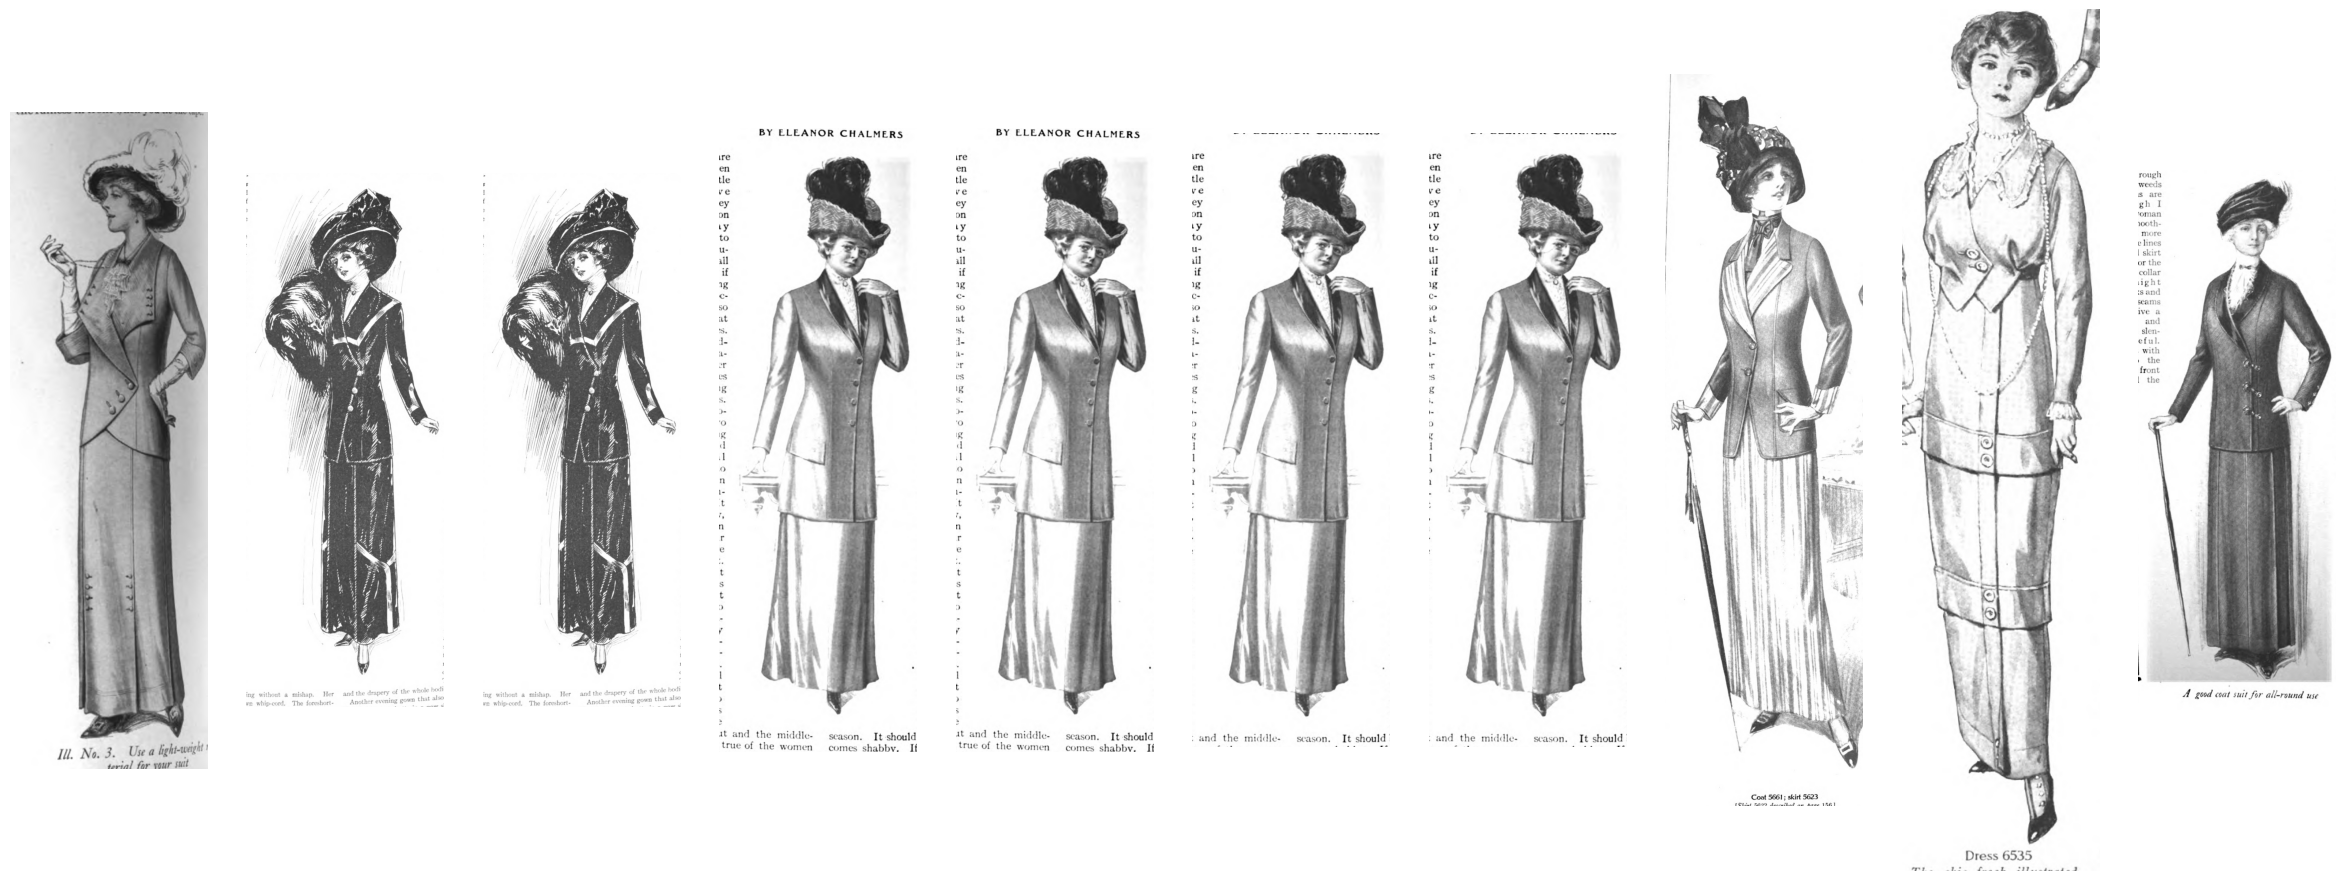

['1912_page_106_extracted_3', '1910_page_426_extracted_3', '1911_page_426_extracted_3', '1910_page_152_extracted_2', '1911_page_152_extracted_2', '1911_page_154_extracted_3', '1910_page_154_extracted_3', '1912_page_153_extracted_3', '1913_page_477_extracted_4', '1912_page_767_extracted_5']


In [169]:
import os  # Adicione isso no início do seu código

try:
    results = collection.query(n_results=10, query_texts=["woman dressing suit"])
    result_ids = results["ids"][0]

    # Exibir imagens dos resultados
    fig, axes = plt.subplots(1, len(result_ids), figsize=(30, 30))
    
    for i, result_id in enumerate(result_ids):
        if result_id in data["image_id"].values:  # Verificação correta
            result_image_path = data[data["image_id"] == result_id]['image_path'].iloc[0]  # Ajuste aqui
            if os.path.exists(result_image_path):
                result_image = plt.imread(result_image_path)
                axes[i].imshow(result_image)
                axes[i].axis('off')
    
    plt.show()  # Mostre todas as imagens de uma vez

except Exception as e:
    print(f"Erro durante a consulta: {e}")

print(result_ids)

In [150]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import clear_output, display
import ipywidgets as widgets

try:
    # Query to ChromaDB with all results
    query_text = "a picture of a woman using tie and blazer"
    results = collection.query(query_texts=[query_text], n_results=50)  # Removed result limit
    result_ids = [item for sublist in results["ids"] for item in sublist]  # Flattens list of lists if needed

    # Filter data based on returned IDs
    filtered_data = data[data["image_id"].isin(result_ids)]

    # Check if there are results
    if filtered_data.empty:
        print(f"No results found for query: '{query_text}'")
    else:
        # Function to extract the year from the filename
        def extract_year_from_filename(image_path):
            # Get the filename only, ignoring the directory path
            filename = os.path.basename(image_path)
            # Extract the year from the filename (considering the format 'YYYY_page_...')
            return int(filename.split('_')[0])

        # Add a 'year' column extracted from the image name
        filtered_data['year'] = filtered_data['image_path'].apply(lambda x: extract_year_from_filename(x))

        # Count the number of images per year
        count_by_year = filtered_data.groupby("year").size().reset_index(name="count")

        # Function to display images for a selected year
        def show_images_for_year(year):
            clear_output(wait=True)
            display(widgets.Label(f"Displaying images from the year {year}:"))

            # Filter images by the year extracted from the filename
            year_data = filtered_data[filtered_data["year"] == year]
            num_images = len(year_data)

            if num_images == 0:
                display(widgets.Label(f"No images found for the year {year}."))
                return

            # Determine the number of columns for the grid
            n_cols = 5  # Number of columns in the grid
            n_rows = (num_images // n_cols) + (1 if num_images % n_cols != 0 else 0)

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
            axes = axes.flatten()  # Flatten the list of axes for easy iteration

            # Display images in the grid
            for i, (_, row) in enumerate(year_data.iterrows()):
                if i >= len(axes):
                    break
                ax = axes[i]
                image_path = row["image_path"]
                
                # Check if the image path exists
                if os.path.exists(image_path):
                    image = plt.imread(image_path)
                    ax.imshow(image)
                    ax.axis("off")
                    ax.set_title(f"ID: {row['image_id']}")
                else:
                    ax.axis("off")
                    ax.set_title(f"Image {row['image_id']} not found")

            # Remove extra axes, if any
            for ax in axes[num_images:]:
                ax.axis("off")

            plt.tight_layout()
            plt.show()

        # Create an interactive Plotly graph for the total image count
        fig = go.Figure()
        fig.add_trace(go.Bar(
            x=count_by_year["year"],
            y=count_by_year["count"],
            text=count_by_year["count"],
            textposition="outside"
        ))
        fig.update_layout(
            title=f"Number of Images by Year (Query: {query_text})",
            xaxis_title="Year",
            yaxis_title="Number of Images",
            showlegend=False
        )

        # Widget to capture the year input
        year_input = widgets.IntText(description="Year: ")
        submit_button = widgets.Button(description="Display Images")

        # Function to handle the submit button
        def on_submit(b):
            year = year_input.value
            if year in count_by_year["year"].values:
                show_images_for_year(year)
            else:
                clear_output(wait=True)
                display(widgets.Label(f"No data found for the year: {year}"))

        submit_button.on_click(on_submit)

        # Display the graph and widgets
        display(fig.show())
        display(year_input, submit_button)

except Exception as e:
    print(f"Error during execution: {e}")


C:\Users\lumor\AppData\Local\Temp\ipykernel_21356\1589675267.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



None

IntText(value=0, description='Year: ')

Button(description='Display Images', style=ButtonStyle())

In [108]:
import os
import matplotlib.pyplot as plt

try:
    results = collection.query(n_results=300, query_texts=["the women are"])
    result_ids = results["ids"][0]

    # Defina o caminho da pasta onde deseja salvar as imagens
    pasta_destino = "C:\\Users\\lumor\\Downloads\\woman going to college"  # Substitua pelo caminho desejado

    # Verifique se a pasta existe; se não, crie-a
    if not os.path.exists(pasta_destino):
        os.makedirs(pasta_destino)

    for i, result_id in enumerate(result_ids):
        if result_id in data["image_id"].values:
            result_image_path = data[data["image_id"] == result_id]['image_path'].iloc[0]
            if os.path.exists(result_image_path):
                result_image = plt.imread(result_image_path)
                
                # Salve a imagem na pasta destino
                nome_arquivo = f"imagem_{i}.png"  # Você pode personalizar o nome do arquivo
                caminho_salvar = os.path.join(pasta_destino, nome_arquivo)
                plt.imsave(caminho_salvar, result_image)
                
    print("Imagens salvas com sucesso.")

except Exception as e:
    print(f"Erro durante a consulta: {e}")

print(result_ids)


Imagens salvas com sucesso.
['1909_page_1076_extracted_3', '1914_page_782_extracted_4', '1904_page_1281_extracted_6', '1899_page_1913_extracted_8', '1909_page_257_extracted_2', '1908_page_721_extracted_1', '1909_page_552_extracted_3', '1900_page_955_extracted_6', '1900_page_946_extracted_4', '1900_page_135_extracted_6', '1912_page_892_extracted_6', '1903_page_823_extracted_5', '1908_page_901_extracted_2', '1907_page_1193_extracted_3', '1904_page_1836_extracted_1', '1908_page_1974_extracted_0', '1912_page_959_extracted_7', '1913_page_981_extracted_4', '1905_page_2180_extracted_3', '1908_page_1242_extracted_3', '1914_page_674_extracted_3', '1900_page_636_extracted_6', '1911_page_186_extracted_1', '1910_page_186_extracted_1', '1904_page_2057_extracted_2', '1899_page_1918_extracted_6', '1897_page_122_extracted_0', '1910_page_91_extracted_2', '1911_page_91_extracted_2', '1900_page_1102_extracted_6', '1908_page_749_extracted_1', '1907_page_1066_extracted_5', '1901_page_112_extracted_1', '190

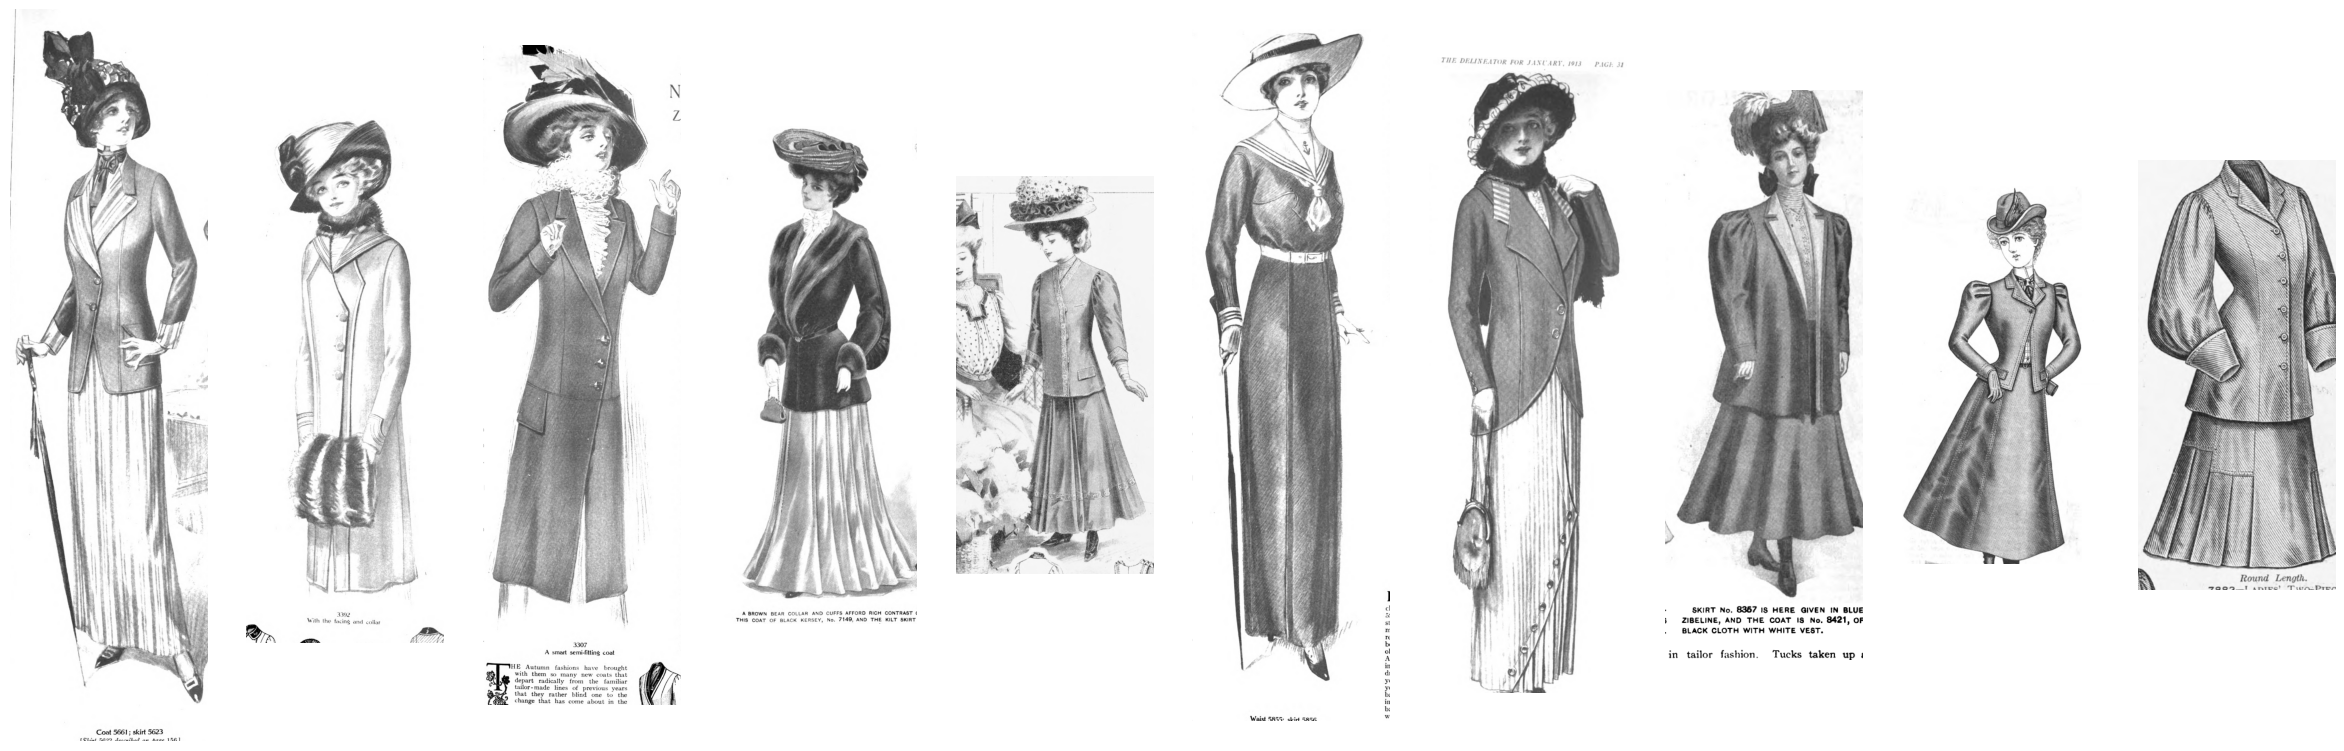

['1912_page_153_extracted_3', '1909_page_408_extracted_0', '1909_page_291_extracted_3', '1903_page_318_extracted_0', '1908_page_1226_extracted_3', '1913_page_575_extracted_5', '1913_page_571_extracted_3', '1905_page_265_extracted_1', '1898_page_689_extracted_4', '1904_page_375_extracted_4']


In [170]:
# Bloco para procurar imagens similares
def find_similar_images(query_image_path, collection, n_results=5):
    # Carrega a imagem e gera embedding
    query_image = cv.imread(query_image_path)
    if query_image is None:
        raise ValueError(f"Imagem não encontrada em {query_image_path}")

    # Gera o embedding da imagem de consulta
    query_embedding = embedding_function([query_image]) # Certifique-se de que o método de embedding está correto

    # Faz a consulta na coleção com a imagem de embedding
    results = collection.query(n_results=n_results, query_embeddings=query_embedding)
    
    return results

# Exemplo de uso
query_image_path ="E:\\The Delineator Cropped Images\\Illustration\\Photograph\\1912_page_153_extracted_3.png" # Ajuste para o caminho da imagem que você deseja consultar
try:
    similar_images = find_similar_images(query_image_path, collection, n_results=10)
    result_ids = similar_images["ids"][0]

    # Exibir imagens similares encontradas
    fig, axes = plt.subplots(1, len(result_ids), figsize=(30, 30))
    
    for i, result_id in enumerate(result_ids):
        if result_id in data["image_id"].values:  # Verificação correta
            result_image_path = data[data["image_id"] == result_id]['image_path'].iloc[0]  # Ajuste aqui
            if os.path.exists(result_image_path):
                result_image = plt.imread(result_image_path)
                axes[i].imshow(result_image)
                axes[i].axis('off')
    
    plt.show()  # Mostre todas as imagens de uma vez

except Exception as e:
    print(f"Erro ao procurar imagens similares: {e}")

print(result_ids)


In [173]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import clear_output, display
import ipywidgets as widgets

try:
    # Path to the query image
    query_image_path = "E:\\The Delineator Cropped Images\\Illustration\\Photograph\\1912_page_153_extracted_3.png"
    
    # Perform image similarity search
    similar_images = find_similar_images(query_image_path, collection, n_results=50)  # Search for similar images
    result_ids = similar_images["ids"][0]  # Get IDs of similar images
    
    # Filter the data based on returned IDs
    filtered_data = data[data["image_id"].isin(result_ids)]
    
    # Check if there are results
    if filtered_data.empty:
        print(f"No results found for the image: '{query_image_path}'")
    else:
        # Function to extract the year from the filename
        def extract_year_from_filename(image_path):
            # Get the filename only, ignoring the directory path
            filename = os.path.basename(image_path)
            # Extract the year from the filename (assuming format 'YYYY_page_...')
            return int(filename.split('_')[0])

        # Add a 'year' column extracted from the image filename
        filtered_data['year'] = filtered_data['image_path'].apply(lambda x: extract_year_from_filename(x))

        # Count the number of images per year
        count_by_year = filtered_data.groupby("year").size().reset_index(name="count")

        # Function to display images for a selected year
        def show_images_for_year(year):
            clear_output(wait=True)
            display(widgets.Label(f"Displaying images from the year {year}:"))

            # Filter images by the year extracted from the filename
            year_data = filtered_data[filtered_data["year"] == year]
            num_images = len(year_data)

            if num_images == 0:
                display(widgets.Label(f"No images found for the year {year}."))
                return

            # Determine the number of columns for the grid
            n_cols = 5  # Number of columns in the grid
            n_rows = (num_images // n_cols) + (1 if num_images % n_cols != 0 else 0)

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
            axes = axes.flatten()  # Flatten the list of axes for easy iteration

            # Display images in the grid
            for i, (_, row) in enumerate(year_data.iterrows()):
                if i >= len(axes):
                    break
                ax = axes[i]
                image_path = row["image_path"]
                
                # Check if the image path exists
                if os.path.exists(image_path):
                    image = plt.imread(image_path)
                    ax.imshow(image)
                    ax.axis("off")
                    ax.set_title(f"ID: {row['image_id']}")
                else:
                    ax.axis("off")
                    ax.set_title(f"Image {row['image_id']} not found")

            # Remove extra axes, if any
            for ax in axes[num_images:]:
                ax.axis("off")

            plt.tight_layout()
            plt.show()

        # Create an interactive Plotly graph for the total image count
        fig = go.Figure()
        fig.add_trace(go.Bar(
            x=count_by_year["year"],
            y=count_by_year["count"],
            text=count_by_year["count"],
            textposition="outside"
        ))
        fig.update_layout(
            title=f"Number of Images by Year (Image Query)",
            xaxis_title="Year",
            yaxis_title="Number of Images",
            showlegend=False
        )

        # Widget to capture the year input
        year_input = widgets.IntText(description="Year: ")
        submit_button = widgets.Button(description="Display Images")

        # Function to handle the submit button
        def on_submit(b):
            year = year_input.value
            if year in count_by_year["year"].values:
                show_images_for_year(year)
            else:
                clear_output(wait=True)
                display(widgets.Label(f"No data found for the year: {year}"))

        submit_button.on_click(on_submit)

        # Display the graph and widgets
        display(fig.show())
        display(year_input, submit_button)

except Exception as e:
    print(f"Error during execution: {e}")


C:\Users\lumor\AppData\Local\Temp\ipykernel_21356\1829748195.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



None

IntText(value=0, description='Year: ')

Button(description='Display Images', style=ButtonStyle())